In [23]:
# Python packages
import matplotlib.pyplot as plt
import pickle
import numpy as np
import sys
import os
import pickle
import signal
import argparse
import traceback
import json
import torch
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import pandas as pd

# Project libraries
sys.path.insert(1, '../src/')
import embedding.factory as ebd
import dataset.loader as loader
import train.factory as train_utils

cuda0 = torch.device('cuda:0')

# Load Data

In [24]:
PATHS_TO_ORACLE_EBD = ['20news_oracle_embed_idf.json', 'huffpost_oracle_embed_idf.json']
PATHS_TO_TOPIC_EBD = ['20news_topic_embed_.json', 'huffpost_topic_embed_.json']

classes_20 = [
    'mideast', 'space', 'sale', 'politics', 'graphics',
    'cryptography', 'windows', 'microsoft', 'guns',
    'religion', 'autos', 'medicine', 'mac', 'electronics',
    'hockey', 'atheism', 'motorcycles', 'pc', 'baseball', 'christian'
]

classes_h = [
    'politics', 'wellness', 'entertainment', 'travel', 'beauty', 'parenting', 'healthy', 'queer',
    'food', 'business', 'comedy', 'sports', 'black', 'home', 'parents', 'the worldpost',
    'weddings', 'women', 'impact', 'divorce', 'crime', 'media', 'weird', 'green', 'worldpost', 'religion',
    'style', 'science', 'worldnews', 'taste', 'tech', 'money', 'arts', 'fifty', 'goodnews', 'arts & culture',
    'environment', 'college', 'latino', 'culture & arts', 'education'
]

# Get topic or oracle embeddings
oracle_embeds = {}
for path in PATHS_TO_ORACLE_EBD:
    name = path.split('_')[0]
    with open('../cached_embeds/{}'.format(path)) as json_file:
        oracle_embeds[name] = json.load(json_file)
        
topic_embeds = {}
for path in PATHS_TO_TOPIC_EBD:
    name = path.split('_')[0]
    with open('../cached_embeds/{}'.format(path)) as json_file:
        topic_embeds[name] = json.load(json_file)

In [25]:
oracle_embeds

{'20news': {'0': [-0.18230870366096497,
   -0.22349849343299866,
   -0.2522120177745819,
   0.35735657811164856,
   -0.21390609443187714,
   0.02196057140827179,
   0.10293538123369217,
   -0.36317989230155945,
   -0.02871885523200035,
   0.3690263330936432,
   0.007583245635032654,
   0.11042387783527374,
   -0.204603910446167,
   -0.03520593047142029,
   0.10731077939271927,
   -0.3549385964870453,
   -0.0726194828748703,
   -0.05209409445524216,
   0.21036958694458008,
   0.41049033403396606,
   -0.23592324554920197,
   0.39623090624809265,
   -0.32326242327690125,
   -0.23146659135818481,
   -0.11797159910202026,
   -0.15754026174545288,
   0.10845468938350677,
   0.030728384852409363,
   0.07278314232826233,
   0.28658565878868103,
   -0.3246440887451172,
   0.3491523861885071,
   -0.4994395673274994,
   0.15087074041366577,
   0.058606404811143875,
   -0.23782138526439667,
   0.03765948861837387,
   -0.23840756714344025,
   0.1404162049293518,
   -0.14561760425567627,
   0.126753

In [26]:
# Define train, val, test sets
train_classes_20 = [1, 5, 10, 11, 13, 14, 16, 18]  
val_classes_20 = [4, 6, 7, 12, 17]
test_classes_20 = [0, 2, 3, 8, 9, 15, 19]

train_h = list(range(20))
val_h = list(range(20,25))
test_h = list(range(25,41))

## Define datasets

In [27]:
NEWS_20 = True

In [28]:
# Datasets, input, output
train, val, test = (train_classes_20, val_classes_20, test_classes_20) if NEWS_20 else (train_h, val_h, test_h)

dataset = '20news' if NEWS_20 else 'huffpost'
topic_embs = topic_embeds[dataset]
oracle_embs = oracle_embeds[dataset]

In [29]:
x =  torch.tensor([topic_embs[str(topic)] for topic in train])# dim N training examples x D_in 
y =  torch.tensor([oracle_embs[str(topic)] for topic in train])# dim N training examples x D_out 

print(x.shape)

torch.Size([8, 300])


In [30]:
valx =  torch.tensor([topic_embs[str(topic)] for topic in val])# dim N training examples x D_in 
valy =  torch.tensor([oracle_embs[str(topic)] for topic in val])# dim N training examples x D_out 

In [31]:
testx =  torch.tensor([topic_embs[str(topic)] for topic in test])# dim N training examples x D_in 
testy =  torch.tensor([oracle_embs[str(topic)] for topic in test])# dim N training examples x D_out 

# Neural Network

Goal: implement a small neural network to map topic embeddings to oracle embeddings using L2 distance. Use train, val, test sets defined in the original dataset.

## Train

In [64]:
# Hyperparameters
D_in, H, D_out = 300, 10, 300 # input dim, hidden layer dim, output dim

In [65]:
# Model layers
model_2 = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out)
)

model_1 = torch.nn.Sequential(
    torch.nn.Linear(D_in, D_out),
#     torch.nn.Dropout(p=0.3)
)

In [66]:
# Model layers
model = model_1

# Loss, learning rate
loss_fn = torch.nn.MSELoss(reduction='mean')
learning_rate = 1e-5
num_iters = 2500
log_every = 5

# Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train
loss_log = []
val_loss_log = []
print('Training on dataset {}'.format(dataset))
for t in range(num_iters):
    # Compute predicted y
    y_pred = model(x)
    
    # Compute loss
    loss = loss_fn(y_pred, y)
    
    if t % log_every == 0:
        # print('Time step: ', t)
        val_predy = model(valx)
        val_loss = loss_fn(val_predy, valy)
        loss_log.append(loss.item())
        val_loss_log.append(val_loss.item())
        # print('Validation loss: ', val_loss.item())
        # print('Training loss: ', loss.item())
    
    # Zero grads, run backward pass, update params
    model.zero_grad()
    loss.backward()
    optimizer.step()
    
print('Final val loss: ', val_loss_log[-1])
print('Final train loss: ', loss_log[-1])

Training on dataset 20news
Final val loss:  0.02883915975689888
Final train loss:  5.847687862114981e-05


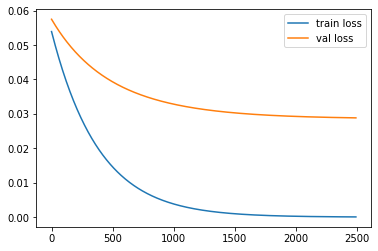

In [67]:
plt.plot([log_every * t for t in range(len(loss_log))], loss_log, label='train loss')
plt.plot([log_every * t for t in range(len(loss_log))], val_loss_log, label='val loss')
plt.legend()

# Test

In [68]:
test_predy = model(testy)
print('Test loss: ', loss_fn(test_predy, testy).item())

Test loss:  0.013458682224154472


In [14]:
print(test_predy)
print(loss_fn(testy, test_predy))
print(test_predy.shape)

print(val_predy)
print(loss_fn(valy, val_predy))
print(val_predy.shape)

print(y_pred.detach().numpy())
print(y_pred.shape)

tensor([[-0.5800, -0.6082, -1.1638,  ...,  1.9016,  1.6120, -0.0810],
        [-0.4897, -0.4759, -1.1214,  ...,  1.8327,  1.5739, -0.0328],
        [-0.5586, -0.5963, -1.1385,  ...,  1.9433,  1.6221, -0.1002],
        ...,
        [-0.5851, -0.7044, -1.3323,  ...,  1.9678,  1.6935, -0.0543],
        [-0.4685, -0.4752, -0.9308,  ...,  1.4602,  1.3137,  0.0279],
        [-0.5663, -0.5490, -1.1108,  ...,  1.8487,  1.5503, -0.0422]],
       grad_fn=<AddmmBackward>)
tensor(0.4669, grad_fn=<MeanBackward0>)
torch.Size([16, 300])
tensor([[-0.1172, -0.2439, -0.5044,  ...,  0.5531,  0.4431,  0.0053],
        [-0.0747, -0.3211, -0.3410,  ...,  0.4385,  0.4422,  0.0571],
        [-0.0135, -0.0904, -0.2426,  ...,  0.4001,  0.3671, -0.0075],
        [-0.1352, -0.2074, -0.3502,  ...,  0.4869,  0.4324, -0.0356],
        [-0.3446, -0.5424, -0.5049,  ...,  0.5268,  0.4144,  0.2037]],
       grad_fn=<AddmmBackward>)
tensor(0.0301, grad_fn=<MeanBackward0>)
torch.Size([5, 300])
[[-0.24744947 -0.5046452  -0

# Vector Offset

Computes oracle - topic for each datapoint in training + validation set. Then graphs them to see how close they are to each other compared to topic to topic or oracle to oracle distances.

In [118]:
train_names = [classes_20[t] for t in train]
val_names = [classes_20[t] for t in val]

train_names.extend(val_names)
train_names

['space',
 'cryptography',
 'autos',
 'medicine',
 'electronics',
 'hockey',
 'motorcycles',
 'baseball',
 'graphics',
 'windows',
 'microsoft',
 'mac',
 'pc']

In [119]:
vs = []

for dataset in [x, valx]:
    for i, vec in enumerate(dataset):
        vs.append((y[i] - vec).detach().numpy())

    
vs = np.array(vs)
vs.shape

(13, 300)

In [87]:
def PCA_(n, df):
    """
    PCAs df into n-dimensional df.
    """
    pca = PCA(n_components=n)
    pca_df = pca.fit_transform(df)
    print('PCAed into shape: ', pca_df.shape)
    return pca_df

In [88]:
def tSNE(df):
    """
    t-SNEs df into 2 dimensions for visualization
    """
    X_embed = TSNE(n_components=2).fit_transform(df)
    print('t-SNEd into shape:', X_embed.shape)
    
    return X_embed

In [89]:
def plot_embeds(embeds, names, title='tSNE Visualization of Distances'):
    """
    Plots embeddings with their corresponding names.
    
    embeds: N x 300 df
    
    """
    small_embeds = tSNE(PCA_(len(names), embeds)) # np array of embeddings
    
    for i, embed in enumerate(small_embeds):
        plt.scatter(embed[0], embed[1])
        plt.text(embed[0]+0.05, embed[1]-0.07, names[i], fontsize=9)
    
    plt.title(title)
    plt.show()

PCAed into shape:  (25, 25)
t-SNEd into shape: (25, 2)


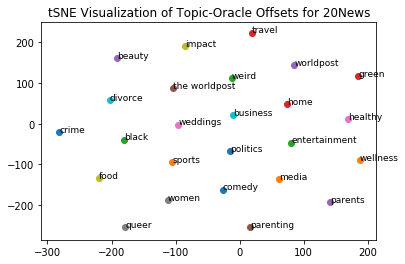

In [125]:
embeds = vs
plot_embeds(embeds, train_names, title='tSNE Visualization of Topic-Oracle Offsets for 20News')

## MLE

In [120]:
# Compute MLE across training
v = np.mean(vs, axis=0)
v.shape

(300,)

In [121]:
# Compute MSEs
y_train_pred = np.add(x_train, v.reshape(v.shape[0], 1))
y_test_pred = np.add(x_testmle, v.reshape(v.shape[0], 1))
train_loss = mean_squared_error(y_train, y_train_pred)
test_loss = mean_squared_error(y_testmle, y_test_pred)


In [122]:
print("Train MSE: ", train_loss)
print("Test MSE: ", test_loss)

Train MSE:  0.048125584
Test MSE:  0.055790395


In [127]:
d = {}
for topic in topic_embeds['huffpost']:
    d[topic] = list(topic_embeds['huffpost'][topic] + v)

d

{'0': [-0.2585144854736328,
  -0.6278219154071808,
  -0.3933537499771118,
  0.4806066350059509,
  -0.32530233031272887,
  0.13433780905103682,
  0.11779252679470927,
  -0.8127544191074372,
  0.09951735138893128,
  0.6825831941986085,
  0.24337169101524353,
  0.18269875604331492,
  -0.2856508535337448,
  -0.3910279806303978,
  0.3400543992614746,
  -0.8399993364334106,
  -0.4054838385105133,
  -0.10756883655905725,
  0.18371555370569229,
  1.0227039276123047,
  -0.7213752337694168,
  0.9296522798633575,
  -0.5112136843223571,
  -0.7795843954372406,
  -0.11934635098838806,
  -0.242486461019516,
  0.2161408219718933,
  -0.11331786241441966,
  0.19212206879854204,
  0.5626978374576568,
  -0.45934586441993713,
  0.9614238237190247,
  -1.0460328556060792,
  0.4706140860366821,
  -0.14939705053806304,
  -0.7028309191799164,
  0.23328895638942718,
  -0.3599092241439819,
  0.09321886878347396,
  -0.29943580012390136,
  -0.03163828820228576,
  -0.15624409321594238,
  -0.14788248513031005,
  0.08

# Shear and Vector Offset

Learn parameters $A \in \mathbb{R}^{300 \times 300}$ and $v \in \mathbb{R}^{300}$ where 

$$y = Ax + v$$
and $A$ is diagonal. What this does is shears the topic embedding ($x$) and adds a vector offset. The individual rows of $A$ and $v$ are decoupled, meaning we can treat this as $300$ separate single-variable linear regressions with $N$-topics datapoints each. There is then a unique MLE for each parameter estimated. 

The MLE for $A_i$ is $$\hat A_i = \frac{\sum_{j=1}^n (x_i^j - \bar x_i)(y_i^j - \bar y_i)}{\sum_{i=1}^n (x_i^j - \bar x_i)^2},$$
sample covariance over sample variance. The MLE for $v_i$ is 
$$\hat v_i = \bar y_i - \hat A_i \bar x_i.$$


In [74]:
def ai_hat(y_row, x_row):
    # Calculates MLE for ith term of v
    cov = sum([(x_row[i] - np.mean(x_row)) * (y_row[i] - np.mean(y_row)) for i in range(len(x_row))]) 
    var = sum([(elt - np.mean(x_row))**2 for elt in x_row])
    return cov / var

In [75]:
def vi_hat(y_row, x_row, ai_hat):
    # Calculates MLE for ith term of A
    return np.mean(y_row) - ai_hat * np.mean(x_row)

In [76]:
def est_MLE(y, x):
    # y: 300 x k
    # x: 300 x k
    
    assert x.shape[0] == y.shape[0] == 300
    
    A, v = [], []
    
    for i in range(len(x)):
        a_i = ai_hat(y[i], x[i])
        v_i = vi_hat(y[i], x[i], a_i)
        
        A.append(a_i)
        v.append(v_i)
    
    return np.array(A), np.array(v)

## Estimate

In [72]:
from sklearn.metrics import mean_squared_error

In [103]:
# Define training datasets and estimate MLEs
x_tr = x.detach().numpy().T
x_val = valx.detach().numpy().T
x_train = np.concatenate((x_tr, x_val), axis=1)

y_tr = y.detach().numpy().T
y_val = valy.detach().numpy().T
y_train = np.concatenate((y_tr, y_val), axis=1)

A, v = est_MLE(y_train, x_train)
A = np.diag(A)

In [104]:
def pred(x, A, v):
    return np.matmul(A, x) + np.vstack([v for i in range(x.shape[1])]).T

In [105]:
# Train MSE
y_pred = pred(x_train, A, v)
train_loss = mean_squared_error(y_train, y_pred)
print('Training MSE: ', train_loss)

Training MSE:  0.0011353908247693119


In [106]:
# Test MSE
x_testmle, y_testmle = testx.detach().numpy().T, testy.detach().numpy().T
y_pred_test = pred(x_testmle, A, v)
test_loss = mean_squared_error(y_testmle, y_pred_test)

print('Test MSE: ', test_loss)

Test MSE:  0.003851224612033339


In [107]:
# Right format for caching
y_pred = list(y_pred.T)
y_pred_test = list(y_pred_test.T)

# Simple Linear Regression

In [9]:
import statsmodels.api as sm

In [12]:
x.shape
y.shape

torch.Size([20, 300])

In [10]:
exog = sm.add_constant(x.detach().numpy(), prepend=False)
endog = y.detach().numpy()

mod = sm.OLS(endog, exog)
res = mod.fit_regularized()

print(res.summary())

ValueError: operands could not be broadcast together with shapes (20,300) (20,) 

# Cache embed vecs 

In [82]:
def store_embed(d, topics, tensor):
    """
    d: dict to store embeds
    topics: [1, 3, 4, 5] etc list of topic indices
    tensor: the array of size len(topics) x embed_dim matrix of word embeddings
    """
    for i, t in enumerate(topics):
        d[t] = tensor[i].tolist()
    
    return d

In [108]:
d = {}
d = store_embed(d, train + val, y_pred)
d = store_embed(d, test, y_pred_test)

In [109]:
dest_path = '20news_shear_vecoffset_embed.json'
with open('../cached_embeds/{}'.format(dest_path), 'w') as json_file:
    json.dump(d, json_file)